The goal of my project is to examine the factors driving complaints about syringe litter in New York City.

In [1]:
# Install libraries
!pip install geodatasets

# Import libraries
from datetime import datetime
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Data cleaning and exploratory data analysis

## Syringe complaints

In [2]:
# Download the 311 complaints about syringes
syringe_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?descriptor=Syringes&$limit=50000')
syringe_complaints.head(2)

,unique_key,created_date,closed_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,...,vehicle_type,taxi_company_borough,taxi_pick_up_location,bridge_highway_name,bridge_highway_direction,road_ramp,bridge_highway_segment,latitude,longitude,location
0,64674122,2025-04-17T09:40:23.000,NaN,DSNY,Department of Sanitation,Dirty Condition,Syringes,Gutter,11236.0,9501 FLATLANDS AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.642666,-73.902219,"\n, \n(40.642665829963974, -73.90221938882445)"
1,64666992,2025-04-16T19:25:30.000,NaN,DSNY,Department of Sanitation,Dirty Condition,Syringes,Sidewalk,10011.0,8 AVENUE,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.744006,-73.999415,"\n, \n(40.74400581773386, -73.99941536887154)"


In [3]:
# Convert created_date from an object to a date
syringe_complaints['created_date'] = pd.to_datetime(syringe_complaints['created_date'])

# Rename 'created_date' to 'created_datetime'
syringe_complaints = syringe_complaints.rename(columns = {'created_date': 'created_datetime'})

# Extract date, month, and year from 'created_datetime'
syringe_complaints['created_date'] = syringe_complaints['created_datetime'].dt.date
syringe_complaints['created_month'] = syringe_complaints['created_datetime'].dt.month
syringe_complaints['created_year'] = syringe_complaints['created_datetime'].dt.year

In [4]:
# Drop duplicate complaints (same date, latitude, and longitude)
syringe_complaints = syringe_complaints.drop_duplicates(subset = ['created_date', 'latitude', 'longitude'])
syringe_complaints.reset_index(drop = True, inplace = True)

In [5]:
# Look for missing values
syringe_complaints.isna().sum()

,0
unique_key,0
created_datetime,0
closed_date,8
agency,0
agency_name,0
complaint_type,0
descriptor,0
location_type,0
incident_zip,1
incident_address,1


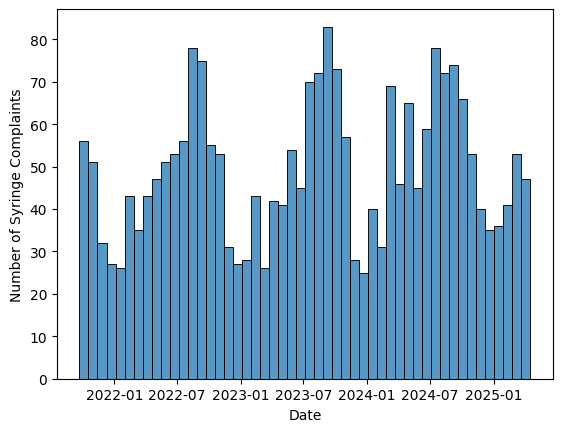

In [6]:
# Make a histogram to show the frequency of syringe complaints
ax = sns.histplot(data=syringe_complaints['created_datetime'], bins = 50)
ax.set_xlabel('Date')
ax.set_ylabel('Number of Syringe Complaints')
plt.show()

Interesting finding: syringe complaints follow a cyclical trend, peaking at similar times each year!

In [ ]:
# Look at the earliest and latest date
print(syringe_complaints['created_datetime'].min())
print(syringe_complaints['created_datetime'].max())

2021-09-22 09:01:47
2025-04-15 11:31:48


In [ ]:
# Keep only complaints from 2022 to 2024 to make later analyses easier
syringe_complaints = syringe_complaints[(syringe_complaints['created_year']>=2022) & (syringe_complaints['created_year']<=2024)]

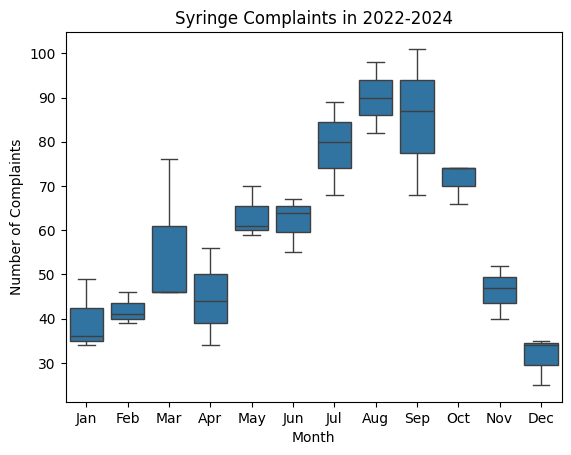

In [ ]:
# Make a boxplot to show the number of syringe complaints each month
ax = sns.boxplot(data = syringe_complaints.groupby(['created_year', 'created_month'])['created_datetime'].agg(complaint_count = 'count').reset_index(),
                 x = 'created_month',
                 y = 'complaint_count')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Complaints')
plt.title('Syringe Complaints in 2022-2024')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

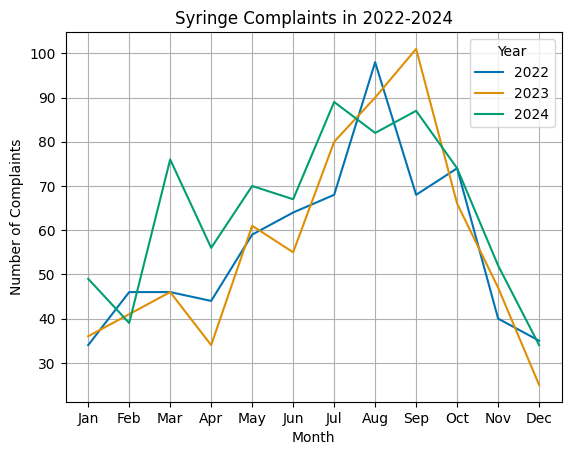

In [ ]:
# Make a lineplot of the number of syringe complaints each month, with a different line pear year
ax = sns.lineplot(data = syringe_complaints.groupby(['created_year', 'created_month'])['created_datetime'].agg(complaint_count = 'count').reset_index(),
                  x = 'created_month',
                  y = 'complaint_count',
                  hue = 'created_year',
                  palette = 'colorblind')
plt.xlabel('Month')
plt.ylabel('Number of Complaints')
plt.title('Syringe Complaints in 2022-2024')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.grid(True)
plt.show()

## Other types of 311 complaints

In [7]:
# Download all of the 311 complaints in 2022, 2023, and 2024
# To limit the size of the download, select only unique_key, created_date, complaint_type, descriptor, longitude, and latitude
all_311_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$query=SELECT%20unique_key,created_date,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude%20WHERE%20date_extract_y(created_date)IN(2022,2023,2024)%20LIMIT%2050000000')
all_311_complaints.head(2)

<ipython-input-7-6ce3a10b2812>:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  all_311_complaints = pd.read_csv('https://data.cityofnewyork.us/resource/erm2-nwe9.csv?$query=SELECT%20unique_key,created_date,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude%20WHERE%20date_extract_y(created_date)IN(2022,2023,2024)%20LIMIT%2050000000')


,unique_key,created_date,complaint_type,descriptor,incident_address,incident_zip,longitude,latitude
0,54157397,2022-05-13T11:49:00.000,Water System,Dirty Water (WE),154 SUMMIT STREET,11231.0,-74.001266,40.681612
1,62114470,2024-08-13T18:00:52.000,UNSANITARY CONDITION,SEWAGE,1496 BUSHWICK AVENUE,11207.0,-73.906732,40.682996


In [8]:
# Convert created_date from an object to a date
all_311_complaints['created_date'] = pd.to_datetime(all_311_complaints['created_date'])

# Rename 'created_date' to 'created_datetime'
all_311_complaints = all_311_complaints.rename(columns = {'created_date': 'created_datetime'})

# Extract date, month, and year from 'created_datetime'
all_311_complaints['created_date'] = all_311_complaints['created_datetime'].dt.date
all_311_complaints['created_month'] = all_311_complaints['created_datetime'].dt.month
all_311_complaints['created_year'] = all_311_complaints['created_datetime'].dt.year

In [9]:
# Remove duplicate complaints
all_311_complaints.drop_duplicates(subset = ['created_date', 'complaint_type', 'descriptor', 'incident_address', 'incident_zip', 'latitude', 'longitude'])
all_311_complaints.reset_index(drop = True, inplace = True)

In [10]:
# Group the 311 complaints by month and year
# Then count the complaints and just the syringe-related complaints
all_311_complaints_monthly = all_311_complaints.groupby(['created_year', 'created_month']).agg(
    all_complaints = ('descriptor', 'count'),
    syringe_complaints = ('descriptor', lambda x: (x == 'Syringes').sum()))

# Divide the syringe-related complaints by the total complaints
all_311_complaints_monthly['syringes/all (%)'] = 100 * all_311_complaints_monthly['syringe_complaints'] / all_311_complaints_monthly['all_complaints']
all_311_complaints_monthly.head(2)

all_complaints  syringe_complaints  \
created_year created_month                                       
2022         1                      272566                  34   
             2                      239223                  48   

                            syringes/all (%)  
created_year created_month                    
2022         1                      0.012474  
             2                      0.020065

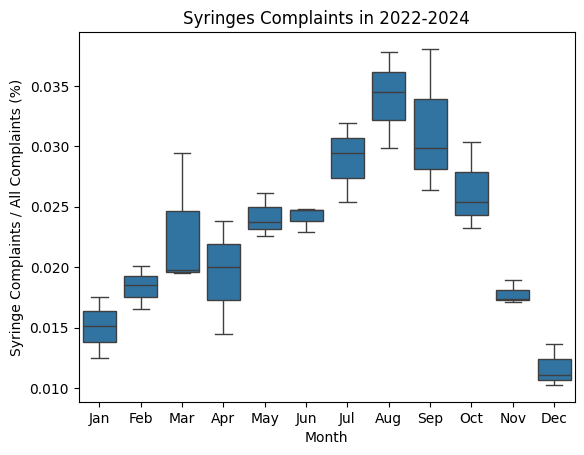

In [ ]:
# Make a boxplot for syringes/all
order = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
ax = sns.boxplot(data = all_311_complaints_monthly,
                 x = 'created_month',
                 y = 'syringes/all (%)',
                 order = order)
ax.set_xlabel('Month')
ax.set_ylabel('Syringe Complaints / All Complaints (%)')
plt.title('Syringes Complaints in 2022-2024')
plt.xticks(range(0, 12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

In [11]:
# Delete all_311_complaints_monthly
del all_311_complaints_monthly

## Geospatial analysis

In [12]:
# Drop columns that won't be needed
all_311_complaints = all_311_complaints.drop(columns = ['incident_address', 'incident_zip'])

In [13]:
all_311_complaints

,unique_key,created_datetime,complaint_type,descriptor,longitude,latitude,created_date,created_month,created_year
0,54157397,2022-05-13 11:49:00,Water System,Dirty Water (WE),-74.001266,40.681612,2022-05-13,5,2022
1,62114470,2024-08-13 18:00:52,UNSANITARY CONDITION,SEWAGE,-73.906732,40.682996,2024-08-13,8,2024
2,54157399,2022-05-13 11:43:00,Water System,Dirty Water (WE),-74.000494,40.682918,2022-05-13,5,2022
3,54157401,2022-05-13 11:37:00,Water System,Dirty Water (WE),-74.000671,40.687178,2022-05-13,5,2022
4,54157398,2022-05-13 11:49:00,Water System,Dirty Water (WE),-73.999975,40.686605,2022-05-13,5,2022
...,...,...,...,...,...,...,...,...,...
9853706,54157404,2022-05-13 11:32:00,Water System,Dirty Water (WE),-73.998850,40.688929,2022-05-13,5,2022
9853707,54157402,2022-05-13 11:33:00,Water System,Dirty Water (WE),-73.999084,40.687766,2022-05-13,5,2022
9853708,54157400,2022-05-13 11:38:00,Water System,Dirty Water (WE),-73.998341,40.687521,2022-05-13,5,2022
9853709,62114367,2024-08-13 11:41:19,ELECTRIC,LIGHTING,-73.868626,40.865410,2024-08-13,8,2024


In [14]:
# Drop rows that do not have latitude and longitude data
all_311_complaints = all_311_complaints.dropna(subset = ['latitude', 'longitude'], how = 'any', ignore_index = True)

In [15]:
# Convert all_311_complaints into a GeoDataFrame in the NAD83 / New York Long Island (ftUS) coordinate reference system
all_311_complaints = gpd.GeoDataFrame(all_311_complaints,
                                      geometry = gpd.points_from_xy(all_311_complaints.longitude, all_311_complaints.latitude),
                                      crs = 'EPSG:4326')
all_311_complaints = all_311_complaints.to_crs(2263)

In [16]:
# Load map of NYC for plotting, CRS = 2263 (NAD83 / New York Long Island (ftUS))
nyc = gpd.read_file(geodatasets.get_path('nybb'))
nyc.crs

Extracting 'nybb_16a/nybb.shp' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.shx' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.dbf' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'
Extracting 'nybb_16a/nybb.prj' from '/root/.cache/geodatasets/nybb_16a.zip' to '/root/.cache/geodatasets/nybb_16a.zip.unzip'


<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US survey foot)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

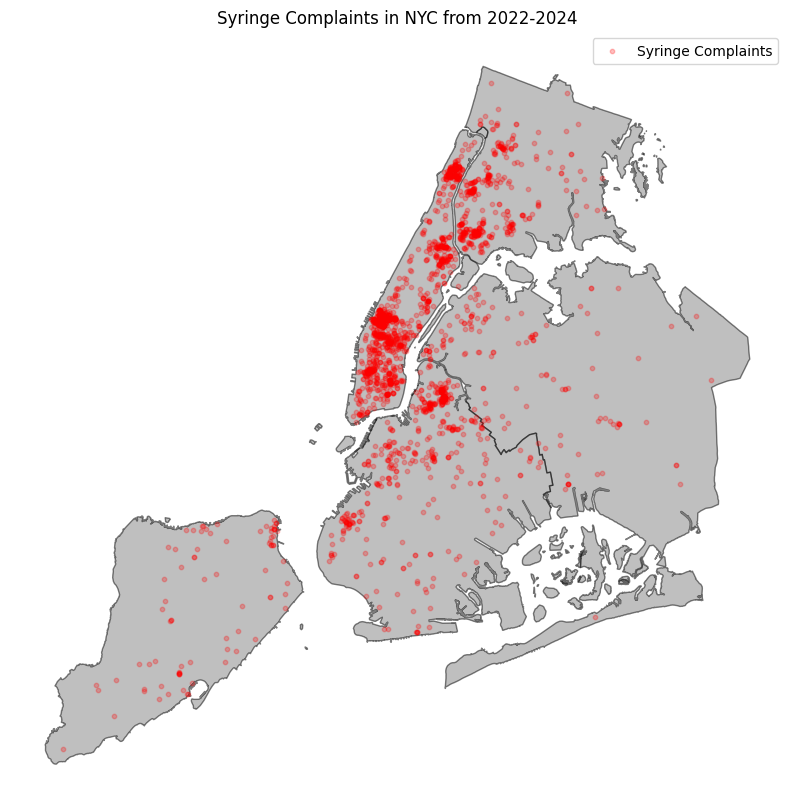

In [17]:
# Plot the syringe complaints on a map of NYC
ax = nyc.plot(figsize = (10, 10), alpha = 0.5, color = 'gray', edgecolor = 'k')

# Plot the syringe complaints and dropoff locations
all_311_complaints[all_311_complaints['descriptor']=='Syringes'].plot(ax = ax, markersize = 10, alpha = 0.25, color = 'red')

# Format the plot
ax.set_axis_off()
ax.legend(['Syringe Complaints'])
plt.title('Syringe Complaints in NYC from 2022-2024')
plt.show()

In [21]:
# Download the sharps dropoff site data
dropoff_sites = pd.read_csv('https://data.cityofnewyork.us/resource/edk2-vkjh.csv')
dropoff_sites.head(2)

,borough,ntaname,site_type,sitename,zipcode,phonenum,days_hours,address,borocd,notes,...,councildist,senate_district,_congress_district,assembly_district,police_precints,bbl,bin,latitude,longitude,point
0,Bronx,Norwood,SYRINGE/SHARPS Drop-off,North Central Bronx Hospital,10467,718-918-5000,24/7,"3424 Kossuth Ave, Bronx, NY 10467",207,Lobby,...,11,33,15,81,52,2.033270e+09,2017787.0,40.880432,-73.881204,POINT (-73.881205418129 40.8804402931774)
1,Queens,Flushing-Willets Point,SYRINGE/SHARPS Drop-off,Union Plaza Care Center,11354,718-670-0765,10am-2pm,"33-23 Union St. Flushing, NY 11354",407,Lobby,...,20,16,6,40,109,4.049810e+09,4112550.0,40.767323,-73.826924,POINT (-73.8269253950036 40.7673312732314)


In [22]:
# Keep only the sharps dropoff sites
dropoff_sites = dropoff_sites[dropoff_sites['site_type'] == 'SYRINGE/SHARPS Drop-off']

# Keep only the relevant columns in dropoff_sites
dropoff_sites = dropoff_sites[['sitename', 'days_hours', 'latitude', 'longitude']]
dropoff_sites = dropoff_sites.reset_index(drop = True)

In [23]:
# Look at the values in the 'days_hours' column
dropoff_sites['days_hours'].value_counts()

,count
days_hours,
24/7,26
Monday-Friday 9am-5pm,19
9am-5pm,14
Monday-Friday 8am-4pm,7
10am-4pm,4
...,...
Monday-Thursday 10am-3pm,1
Monday-Sunday 11am-1pm,1
"Monday, Tuesday, Friday 9am-5pm; Wednesday 10AM-5PM; Thursday 9AM-7PM",1


In [24]:
# Use Google's Gemini LLM to parse the 'days_hours' column into something more quantifiable

# Import the necessary libraries
from IPython.display import HTML, Markdown, display
from google.colab import userdata
from google.api_core import retry
from google import genai
from pydantic import BaseModel

# Get the Google API key
GOOGLE_API_KEY = userdata.get('google_api_key')

# Handle errors
is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})
genai.models.Models.generate_content = retry.Retry(
    predicate=is_retriable)(genai.models.Models.generate_content)

# Initialize the genAI client
client = genai.Client(api_key=GOOGLE_API_KEY)

# Define what the LLM's response should look like
class Response(BaseModel):
  logical: str
  hours_per_month: int

# For each dropoff site, ask whether the dropoff hours make sense
# If so, calculate the hours the site is open in a 28-day month
for i in range(len(dropoff_sites)):
  response = client.models.generate_content(
      model='gemini-2.0-flash',
      contents=f'''The site hours are {dropoff_sites.loc[i, 'days_hours']}. Does this make logical sense, Yes or No?
      How many hours in a 28-day month is the site open?''',
      config={
          'response_mime_type': 'application/json',
          'response_schema': list[Response],
      },
  )

  # Save the calculated hours
  if response.parsed[0].logical == 'Yes':
    dropoff_sites.loc[i, 'hours_per_month'] = response.parsed[0].hours_per_month
  else:
    dropoff_sites.loc[i, 'hours_per_month'] = np.nan

  # Track progress
  if i % 50 == 0:
    print(f'Progress: {i} rows')

Progress: 0 rows
Progress: 50 rows
Progress: 100 rows
Progress: 150 rows


In [27]:
dropoff_sites.head(2)

,sitename,days_hours,latitude,longitude,hours_per_month
0,North Central Bronx Hospital,24/7,40.880432,-73.881204,672.0
1,Union Plaza Care Center,10am-2pm,40.767323,-73.826924,112.0
